In [18]:
from operator import add
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
import csv

In [8]:
conf = SparkConf()
sc = SparkContext(conf=conf)
fl = './data/graph_picked.csv'
beta = 0.8 #usually 0.8-0.9
iterations = 40

In [9]:
rdd = sc.textFile(fl).filter(lambda x: not x.startswith('p1')).map( #remove title
    lambda x: tuple(map(int,x.split(','))))         #(source, destination,counts)
#unqiue id in the rdd
container = set(rdd.flatMap(lambda x: (x[0],x[1])).collect())
n = len(container)
# a dictionary of the degree for a person
degree = rdd.map(lambda x: (x[0],x[2])).groupByKey().mapValues(sum).sortBy(
        lambda x: x[0]).collectAsMap()
#graph:(destination,(source,probability of s->d))
graph = rdd.map(lambda x: (x[1],(x[0],x[2]/degree[x[0]])))

In [10]:
#start iteration r = beta*M*r+(1-beta)/n
r = {x:1/n for x in container}
for i in range(iterations):
    newr = graph.mapValues(lambda x: beta*x[1]*r[x[0]]).reduceByKey(
            add).mapValues(lambda x: x+(1-beta)/n).collectAsMap()
    r = newr
rank = sorted([(x,r[x]) for x in r],key=lambda x: -x[1])
with open("data/pagerank_picked.csv","w") as csvfile:
    wrcsv = csv.writer(csvfile)
    wrcsv.writerow(['name','score'])
    wrcsv.writerows(rank)

In [11]:
edges = graph.map(lambda x: ((min(x[0],x[1][0]),max(x[0],x[1][0])),x[1][1]*r[x[1][0]])).groupByKey().map(
                  lambda x: (x[0][0],x[0][1],sum(x[1]))).sortBy(lambda x:x[0]).collect()
with open("data/ugraph_pagerank_picked.csv","w") as csvfile:
    wrcsv = csv.writer(csvfile)
    wrcsv.writerow(['p1','p2','count'])
    wrcsv.writerows(edges)

In [12]:
sc.stop()

In [16]:
pagerank_picked = pd.read_csv('./data/pagerank_picked.csv')
df_people = pd.read_csv('./data/people.csv')

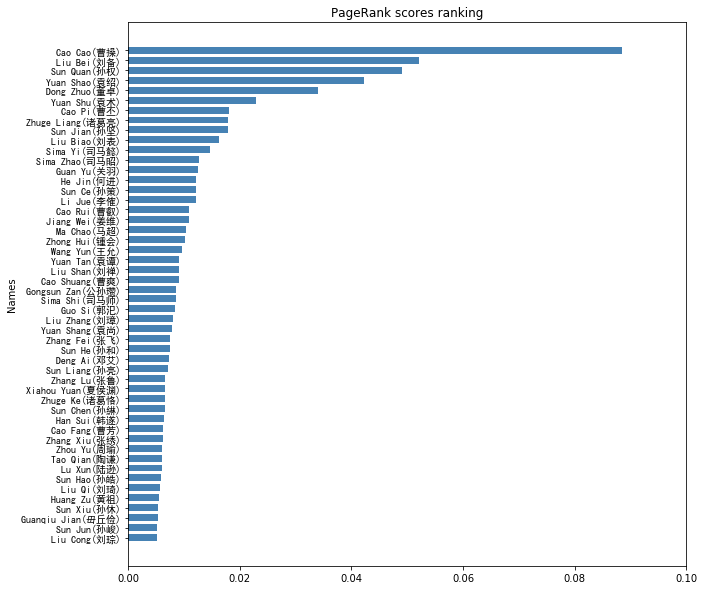

In [23]:
# PageRank scores ranking
plt.figure(figsize = (10, 10))
plt.barh(range(len(pagerank_picked[0:50])), list(pagerank_picked[0:50].score[::-1]), height=0.7, color='steelblue') 
top_people = df_people.iloc[pagerank_picked[0:50].name[::-1]]
plt.yticks(range(len(pagerank_picked[0:50])), 
           [person[1].name_en + '(' + person[1].name_zh + ')' for person in top_people.iterrows()], 
           fontproperties = 'simhei')
plt.xlim(0,0.1)
plt.ylabel("Names")
plt.title("PageRank scores ranking")
plt.show()